# 2개로 진행
- malignant cell만
- malignant cell + OPC + NSC + oligo 

In [1]:
import scanpy as sc
import os
import numpy as np
import loompy as lp

In [2]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/GBmap'
os.listdir(data_path)

['pyega3_output.log',
 'coreGBmap.h5ad',
 '.DS_Store',
 'opc',
 'coreGBmap_var_corrected.h5ad',
 'extendedGBmap.h5ad',
 'total',
 'tumor_only',
 'coreGBmap_bitfam.h5ad']

In [3]:
adata = sc.read_h5ad(os.path.join(data_path, 'coreGBmap.h5ad'))
adata

AnnData object with n_obs × n_vars = 338564 × 27983
    obs: 'author', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'stage', 'location', 'sector', 'sample', 'celltype_original', 'iCNV', 'EGFR', 'MET', 'p53', 'TERT', 'ATRX', 'PTEN', 'MGMT', 'KI_67', 'chr1p19q', 'PDGFR', 'suspension_type', 'donor_id', 'annotation_level_3', 'annotation_level_4', 'annotation_level_2', 'annotation_level_1', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'featur

In [4]:
adata.layers["counts"] = adata.raw.X

/Users/jiehoonk/micromamba/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/jiehoonk/micromamba/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


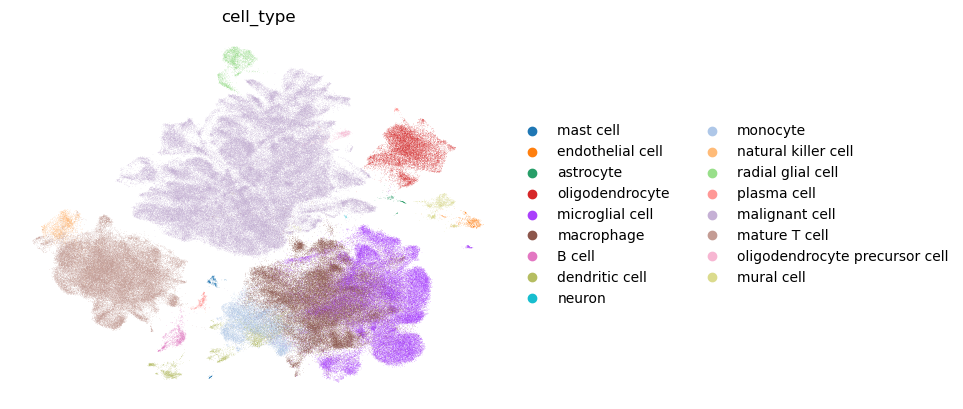

In [7]:
sc.pl.umap(adata, color = "cell_type", frameon= False)

In [13]:
adata.obs.cell_type.value_counts()

cell_type
malignant cell                    127521
macrophage                         61134
microglial cell                    54722
mature T cell                      54257
monocyte                           14215
oligodendrocyte                    12481
dendritic cell                      3961
radial glial cell                   2807
natural killer cell                 2489
mural cell                          1418
B cell                              1250
endothelial cell                     673
plasma cell                          572
oligodendrocyte precursor cell       496
mast cell                            373
astrocyte                            173
neuron                                22
Name: count, dtype: int64

In [5]:
adata.var['gene_id'] = adata.var.index

In [6]:
adata.var.set_index('feature_name', inplace=True)

In [19]:
adata_opc = adata[adata.obs.cell_type.isin(["malignant cell", "oligodendrocyte", "radial glial cell", "oligodendrocyte precursor cell"])]
adata_opc.write_h5ad(os.path.join(data_path, 'coreGBmap_opc.h5ad'))

In [20]:
adata_tumor_only = adata_opc[adata_opc.obs.cell_type.isin(["malignant cell"])]

adata_tumor_only.write_h5ad(os.path.join(data_path, 'coreGBmap_tumor_only.h5ad'))

In [11]:
def create_loom(adata, path):
    row = {"Gene": np.array(adata.var_names)}
    col = {"CellID": np.array(adata.obs_names),"nGene": np.array(np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,"nUMI": np.array(np.sum(adata.X.transpose() , axis=0)).flatten()}
    matrix = adata.X.transpose()
    lp.create(path, matrix, row, col)
    


In [ ]:
create_loom(adata_opc, '~/DevHub/mnt/dataset/GBmap/coreGBmap_opc.loom')

In [22]:
create_loom(adata_tumor_only, '~/DevHub/mnt/dataset/GBmap/coreGBmap_tumor_only.loom')

In [12]:
create_loom(adata, '~/DevHub/mnt/dataset/GBmap/coreGBmap_total.loom')

In [ ]:
singularity run ~/singularity/pyscenic.sif  pyscenic grn coreGBmap_total.loom ~/mnt/annotations/_tf.txt -o adj.csv --num_workers 72